# Import Libraries

In [48]:
import pandas as pd
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from pickle import dump
from sklearn.model_selection import GridSearchCV

In [49]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
df = pd.read_csv(url)
df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


In [50]:
df["is_spam"] = df["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [51]:
print(df.shape)
print(f"Spam: {len(df.loc[df.is_spam == 1])}")
print(f"No spam: {len(df.loc[df.is_spam == 0 ])}")

(2999, 2)
Spam: 696
No spam: 2303


In [52]:
total_data = df.drop_duplicates()
total_data = total_data.reset_index(inplace = False, drop = True)
total_data.shape

(2369, 2)

In [53]:
def preprocess_text(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

total_data["url"] = total_data["url"].apply(preprocess_text)
total_data.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


In [54]:
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

total_data["url"] = total_data["url"].apply(lemmatize_text)
total_data.head(20)

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1
5,"[http, brookings, interactives, reopening, ame...",0
6,"[http, reuters, investigates, special, report,...",0
7,"[http, theatlantic, magazine, archive, superma...",0
8,"[http, john, bolton, book, excerpt, trump, ukr...",0
9,"[http, theguardian, travel, tourism, coronavir...",0


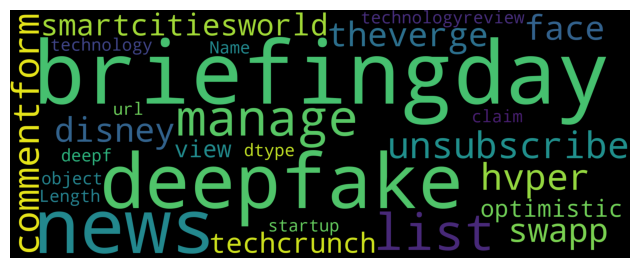

In [55]:
wordcloud = WordCloud(width = 2000, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 24)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [56]:
tokens_list = total_data["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24, stratify = y)
model = SVC(kernel = "linear", random_state = 24)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
train_score = accuracy_score(y_train, y_pred)

y_pred = model.predict(X_test)
test_score = accuracy_score(y_test, y_pred)

overfitting = train_score - test_score

print(train_score)
print(test_score)
print(overfitting)

dump(model, open("/workspaces/alfonsoMG_NLP/models/svc_model.pk", "wb"))

0.9445910290237467
0.9324894514767933
0.012101577546953401


In [57]:
# Define tu conjunto de hiperparámetros
hyper = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}],
    'random_state': [24]
}

# Inicializa el clasificador SVC
svc = SVC()

# Inicializa el GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=hyper, cv=5, scoring='accuracy')

# Ajusta el modelo a tus datos de entrenamiento
grid_search.fit(X_train, y_train)
best_hyper = grid_search.best_params_
# Imprime los mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:")
print(best_hyper)

best_model = SVC(**best_hyper)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_train)
train_score_opt = accuracy_score(y_train, y_pred)
print(f"Accuracy for Train is {train_score_opt}.")
# Obtén la precisión del modelo en los datos de prueba
y_pred = best_model.predict(X_test)
test_score_opt= accuracy_score(y_test, y_pred)
print(f"Accuracy for Test is {test_score_opt}.")


overfitting_opt = train_score_opt - test_score_opt
print(f"The resulting overfitting is of {overfitting_opt} points.")

print(f"The optimizated model has improved:\nTrain in {train_score_opt - train_score}\nTest in {test_score_opt - test_score}\nOverfitting in {overfitting_opt - overfitting} accuracy points.")

dump(model, open("/workspaces/alfonsoMG_NLP/models/svc_model_opt.pk", "wb"))

Mejores Hiperparámetros:
{'C': 1, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'random_state': 24}
Accuracy for Train is 0.9583113456464379.
Accuracy for Test is 0.9388185654008439.
The resulting overfitting is of 0.019492780245594088 points.
The optimizated model has improved:
Train in 0.013720316622691242
Test in 0.006329113924050556
Overfitting in 0.0073912026986406865 accuracy points.
